# Hate Speech Detection

I want to build an algorithim to  categorize tweets.  This will use the Hate Speach and Offensive Language dataset at [https://www.kaggle.com/datasets/mrmorj/hate\-speech\-and\-offensive\-language\-dataset?select=labeled\_data.csv](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?select=labeled_data.csv).  This dataset is 24782 tweets long with users voting on if the tweet is offensive 0, hate speach 1 or neither 2, with the winning label being selected as a class.  

## Goal

My goal is to identify groupings of tweets based on topic.  With 27k+  tweets, I should be able to find 30-50 groups based on topics.

## Approach

I am planning to use a combination of TF-IDF, matrix factorization, and clustering algorithims to tweets by 1 and 2 word clusters.  I will then create similarity tables and use rainbow clustering to find groups of tweets.

### Disclaimer

This assignment necessary contains hate speach, and offensive langauge.  This does not represent the views of the author.



In [97]:
#General Imports
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import statistics
from collections import Counter
#EDA Imports
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from sklearn.metrics import recall_score, precision_score, f1_score

#Model build Imports
from sklearn.cluster import DBSCAN

In [4]:
#Initial Import
raw_data = pd.read_csv('Data/labeled_data.csv', header = 0)
print(raw_data)
raw_data = raw_data.drop(columns = 'Unnamed: 0')
print(statistics.mean(raw_data['tweet'].str.len()))

       Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0                   0        3      2   
1               1      3            0                   3        0      1   
2               2      3            0                   3        0      1   
3               3      3            0                   2        1      1   
4               4      6            0                   6        0      1   
...           ...    ...          ...                 ...      ...    ...   
24778       25291      3            0                   2        1      1   
24779       25292      3            0                   1        2      2   
24780       25294      3            0                   3        0      1   
24781       25295      6            0                   6        0      1   
24782       25296      3            0                   0        3      2   

                                                   tweet  
0      !!! RT @m

## Import and Cleaning

### Import

This data imports fairly easily.  I donloaded a copy of the file from kaggle and mirrored it to my GitHub so I could autodownload it for your use.

### Data Description
The data concists of 24782 tweets which have been user labeled as either hate, offensive, or neither, along with a total cont of votes.

### Cleaning

#### **Tweets with newline**

There appears to be a mismatch between the number of lines generated and the number of lines imported.  This is caused by newline characters, commas, quotation marks, and other supidity mixed in.  I chose to build my own parser to deal with all the issues and allow me to deal with the various problems with the data.\
**Update**\
There are skipped tweet numbers with no indicator in the dataset other than looking.

##### **Some examples of problematic formating.**

22422,3,0,3,0,1,"This bitch fell straight through the chair... Im high, of course I laughed..\
\
\
\
Even if I wasn't I would've still laughed."

256,3,0,3,0,1,"""@TheNewSAT: #NewSATQuestions\
Yeah bitch, yeah bitch, call me _______:\
a.) Maybe\
b.) Steve-O\
c.) Later\
d.) Jesse Pinkman""\
@machinegunkelly"

#### **Username Cleanup**

I chose to just drop all usernames.  This is due to usernames being random characters and it's out of scope for this project to try to do abusive username detection.

#### **Unicode Characters, numbers, and non-text characters**

I also chose to drop all unicode characters (Doing this save soo much time), numbers and most non-text characters.  The exception was the "*" character.  The * character is used to mask offensive words and when used, the resulting word length is fairly standard.

# Initial EDA
The average character count of the uncleaned tweets is 85.  The average word count is 14.  



In [95]:
print("Mean Charater Count: " + str(statistics.mean(raw_data['tweet'].str.len())))
print("Mean Word Count: " + str(np.mean(raw_data['tweet'].apply(lambda x: len([words for words in x.split(" ") if isinstance(x, str)])))))
print("Basic Data Charasitics" + str(Counter(raw_data['class'])))
print("30 Most common words.")
Counter(" ".join(raw_data['tweet']).split()).most_common(30)

Mean Charater Count: 70.88968244361054
Mean Word Count: 15.010006859540814
Basic Data CharasiticsCounter({1: 19190, 2: 4163, 0: 1430})
30 Most common words.


[('i', 9757),
 ('a', 9536),
 ('bitch', 8252),
 ('rt', 7605),
 ('the', 7163),
 ('t', 6816),
 ('you', 6764),
 ('to', 5303),
 ('that', 4017),
 ('and', 3964),
 ('my', 3566),
 ('bitches', 3104),
 ('in', 3045),
 ('is', 2898),
 ('co', 2861),
 ('like', 2765),
 ('me', 2742),
 ('s', 2694),
 ('it', 2666),
 ('of', 2523),
 ('on', 2514),
 ('http', 2428),
 ('hoes', 2386),
 ('be', 2373),
 ('pussy', 2147),
 ('this', 2125),
 ('for', 2100),
 ('all', 1940),
 ('hoe', 1927),
 ('with', 1840)]

In [6]:
def text_cleanup(text):
    #Remove usernames replace @xxx: with whitespace
    text = re.sub("@.*?:", " ", text)
    #remove unicode characters
    text = re.sub("&#[0-9]{1,6};", " ", text)
    #lowercase all text
    text = text.lower()
    #remove URL's
    text = re.sub('http[s]?:\/\/.*?"', " ", text)
    #remove special characters and numberrs'
    #I chose to leave in *'s as they are a common manipulation to get around filters
    text = re.sub("[^a-z\*]", " ", text)
    #remove repeat whitespace and newlines
    text = re.sub("\s\s+", " ", text)
    text = re.sub("\n+", "", text)
    return text
raw_data["tweet"] = raw_data["tweet"].apply(text_cleanup)
print(raw_data['tweet'])

0         rt as a woman you shouldn t complain about cl...
1         rt boy dats cold tyga dwn bad for cuffin dat ...
2         rt you ever fuck a bitch and she start to cry...
3                     rt viva based she look like a tranny
4         rt the shit you hear about me might be true o...
                               ...                        
24778    you s a muthaf***in lie pearls corey emanuel r...
24779    you ve gone and broke the wrong heart baby and...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782     ruffled ntac eileen dahlia beautiful color co...
Name: tweet, Length: 24783, dtype: object


## EDA Procedure

### Basic Data Charaistics After Cleanup

A tweet at the time of this data being collected can contain at maxiumum 280 Characters.  
Mean Char Count
Mean Word Count

### Formatting Data

I will start with dropping all the non-tweet columns.  This will be blind learning.

### Bagging

I chose to use TF\-IDF for my bagging procedure.  I am testing using unigrams single words only.  I may retest this using bigrams later., and am removing common English stopwords.  I decided not to restrict common words as the most common words are 27%.  I may experiment with this later.  

Exploratory analays was done on unigrams and bigrams.  

### DBSCAN
DBSCAN or Density-Based Spatial Clustering of Applications with Noise is a clustering algorithm that uses the density of datapoints to classify objects.  In this case, I'm using DBSCAN to provide coloring of my graphed results.


That's not good.  All of the data seems to be in 1 large clump.  That will not do for classification.  I can try to get rid of the outliers, or I can try to clean the data.  I will try both. 
## Attempt to get rid of highly common elements.
In this I will rerun the TF-IDF with a maximum document frequency of .2 and .15 and see if I get a better spread.

In [91]:
def color_graph(tsne_results):
    dbscan = DBSCAN(eps=2.0, min_samples=100,\
                        metric='euclidean', metric_params=None, \
                        algorithm='auto', leaf_size=30, p=None, \
                        n_jobs=None)
    model_data = pd.DataFrame(tsne_results, columns = ['x', 'y'])
    model = dbscan.fit(tsne_results)
    model_data['predict'] = model.fit_predict(model_data,model_data)
    model_data['predict'] = model_data['predict'].where(model_data['predict'] == 0, 1)

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x=model_data['x'].tolist(), y=model_data['y'].tolist(),
        hue=model_data['predict'].tolist(),
        data=model_data,
        legend="full",
        alpha=0.3
    )
    print(model_data['predict'].value_counts())
    print("Text in the core")
    print (raw_data['tweet'][model_data.loc[model_data['predict'] == 0].index].sample(20))
    print("Text outside the core")
    print (raw_data['tweet'][model_data.loc[model_data['predict'] == 1].index].sample(20))
    return model_data

predict
0    13493
1    11290
Name: count, dtype: int64
Text in the core
5347                              saltlife lol chill pussy
17359    rt and niggas don t be knowing the difference ...
2809                                  cee murda yellow fin
10999    i turned on the bet awards for seconds and got...
10789                          i need some good pussy fuck
13396    no one understands how much it pisses me off w...
20654    see ima stop getting on this here twitter argu...
6458      kieffer jason keep talking i m going to make ...
13453    not sure why someone would put my pictures on ...
14252                               rt got like hoes baes 
7609     all the uchiha are rt sasuke is probably the b...
7591     all my bitches love me all my all my bitches l...
9525     got a iphone for business but the sidekick is ...
18965    rt its am and your man is with his other bitch...
3278      god loves biebs go pray in a church or someth...
10463              i hate ratchet country 

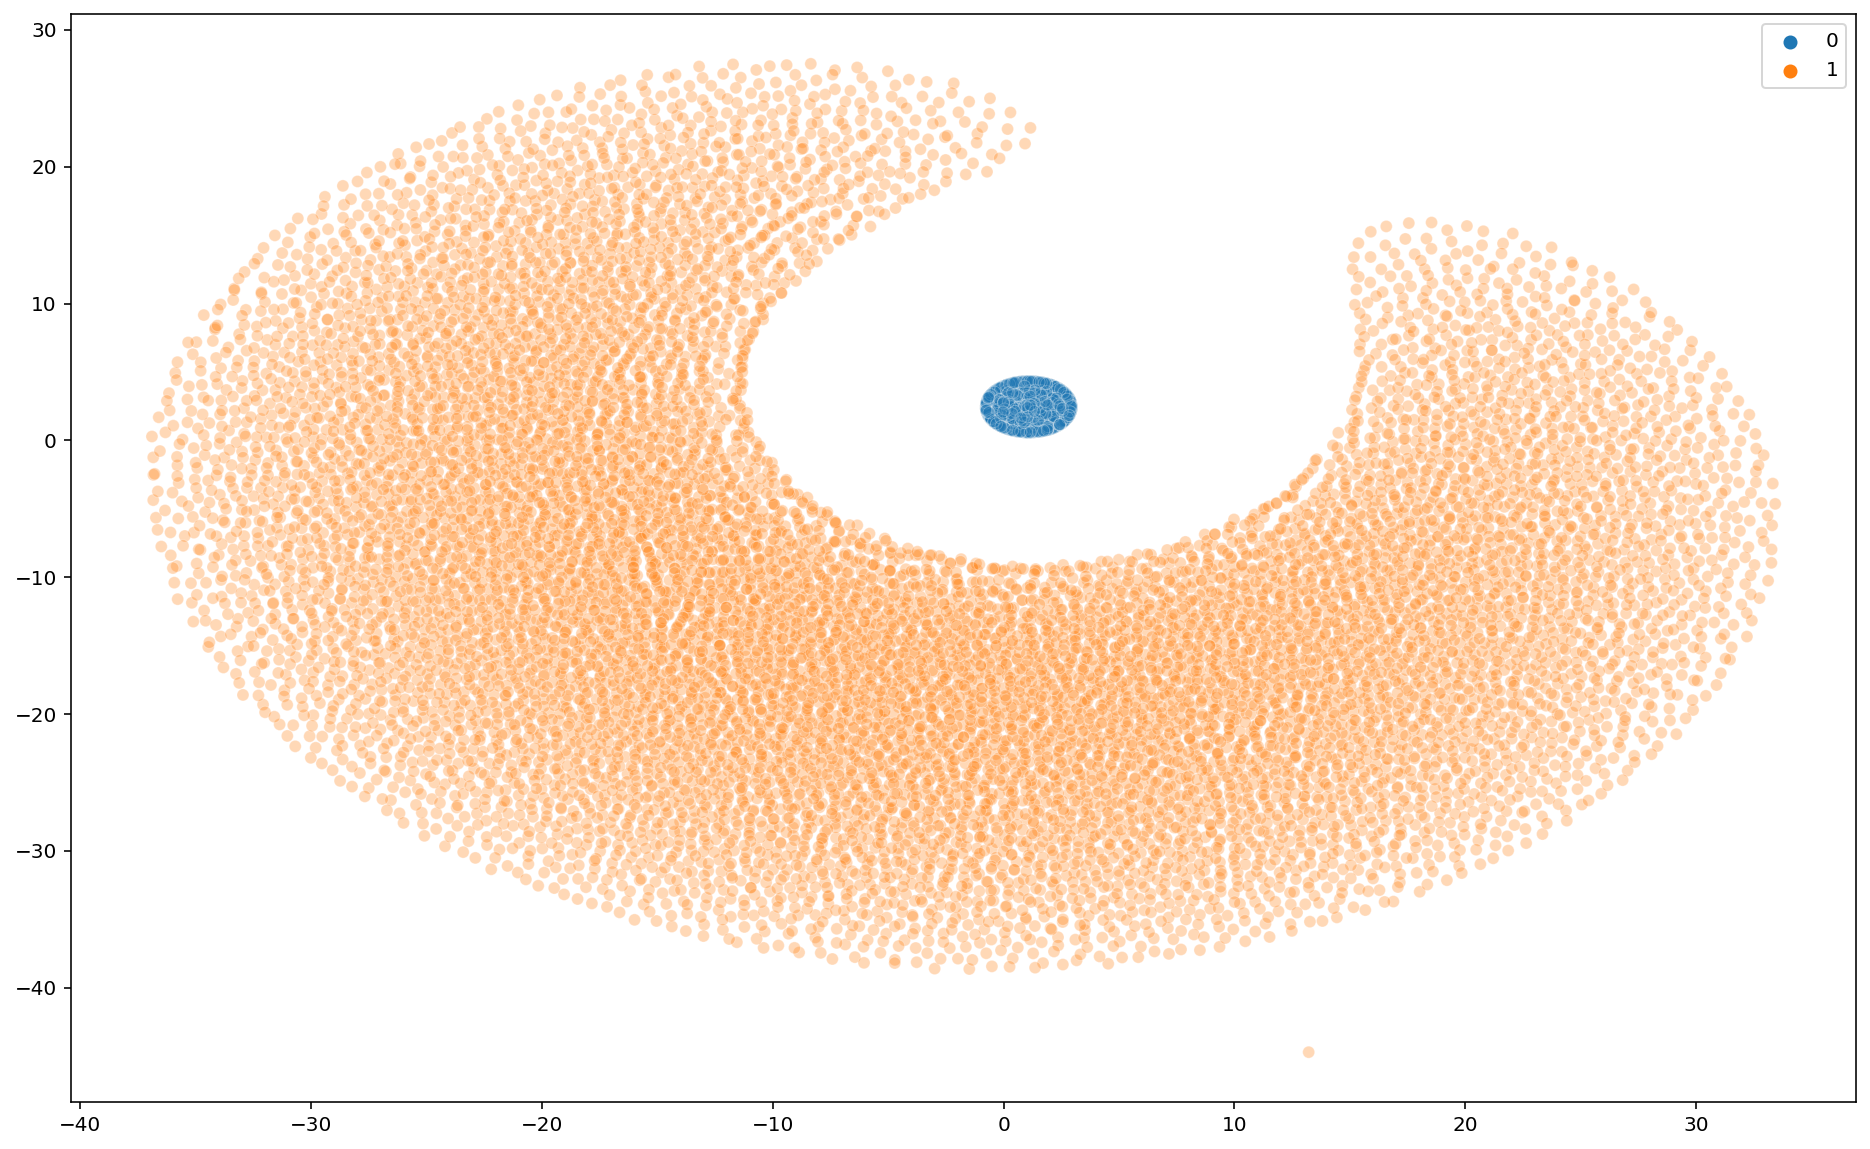

In [92]:
tfidf = TfidfVectorizer(input='content', encoding='utf-8', \
                        decode_error='strict', strip_accents='ascii', \
                        lowercase=True, preprocessor=None, tokenizer=None, \
                        analyzer='word', stop_words='english',  \
                        ngram_range=(1, 1),max_df = 1, max_features=None,\
                        vocabulary=None, binary=False, norm='l2', \
                        use_idf=True, smooth_idf=True, sublinear_tf=False)
tfidf = tfidf.fit(raw_data['tweet'])
tfidf_data = tfidf.transform(raw_data['tweet'])
feature_names = tfidf.get_feature_names_out()

tsne_results_unigrams = TSNE(n_components=2, learning_rate='auto'\
                             ,init='random', perplexity=30, n_iter = 600\
                            ).fit_transform(tfidf_data)
model_data_unigram = color_graph(tsne_results_unigrams)


predict
1    22641
0     2142
Name: count, dtype: int64
Text in the core
6710                                                     *
11403                       i m such a bitch sometimes lol
2413                                                      
17235                 rt i cannot fuck with a broke bitch 
2437                                                      
21702                           there s other bad bitches 
15530    rt a girl tweeted you might be ghetto if u bri...
17061                 rt realniggasherm bitch bitch wassup
12987      my bitch say i m in the dog house fuck you mean
8330     can you imagine tryn yo hardest to stop a bitc...
11882                    it aint nun to cut dat bitch off 
13308            niggas actin like hoes most of em bitches
5350                                       t co nbfaarxvrp
10775                                      i need a bitch 
12595                                            lol bitch
19178    rt a boyfriend and girlfriend sup

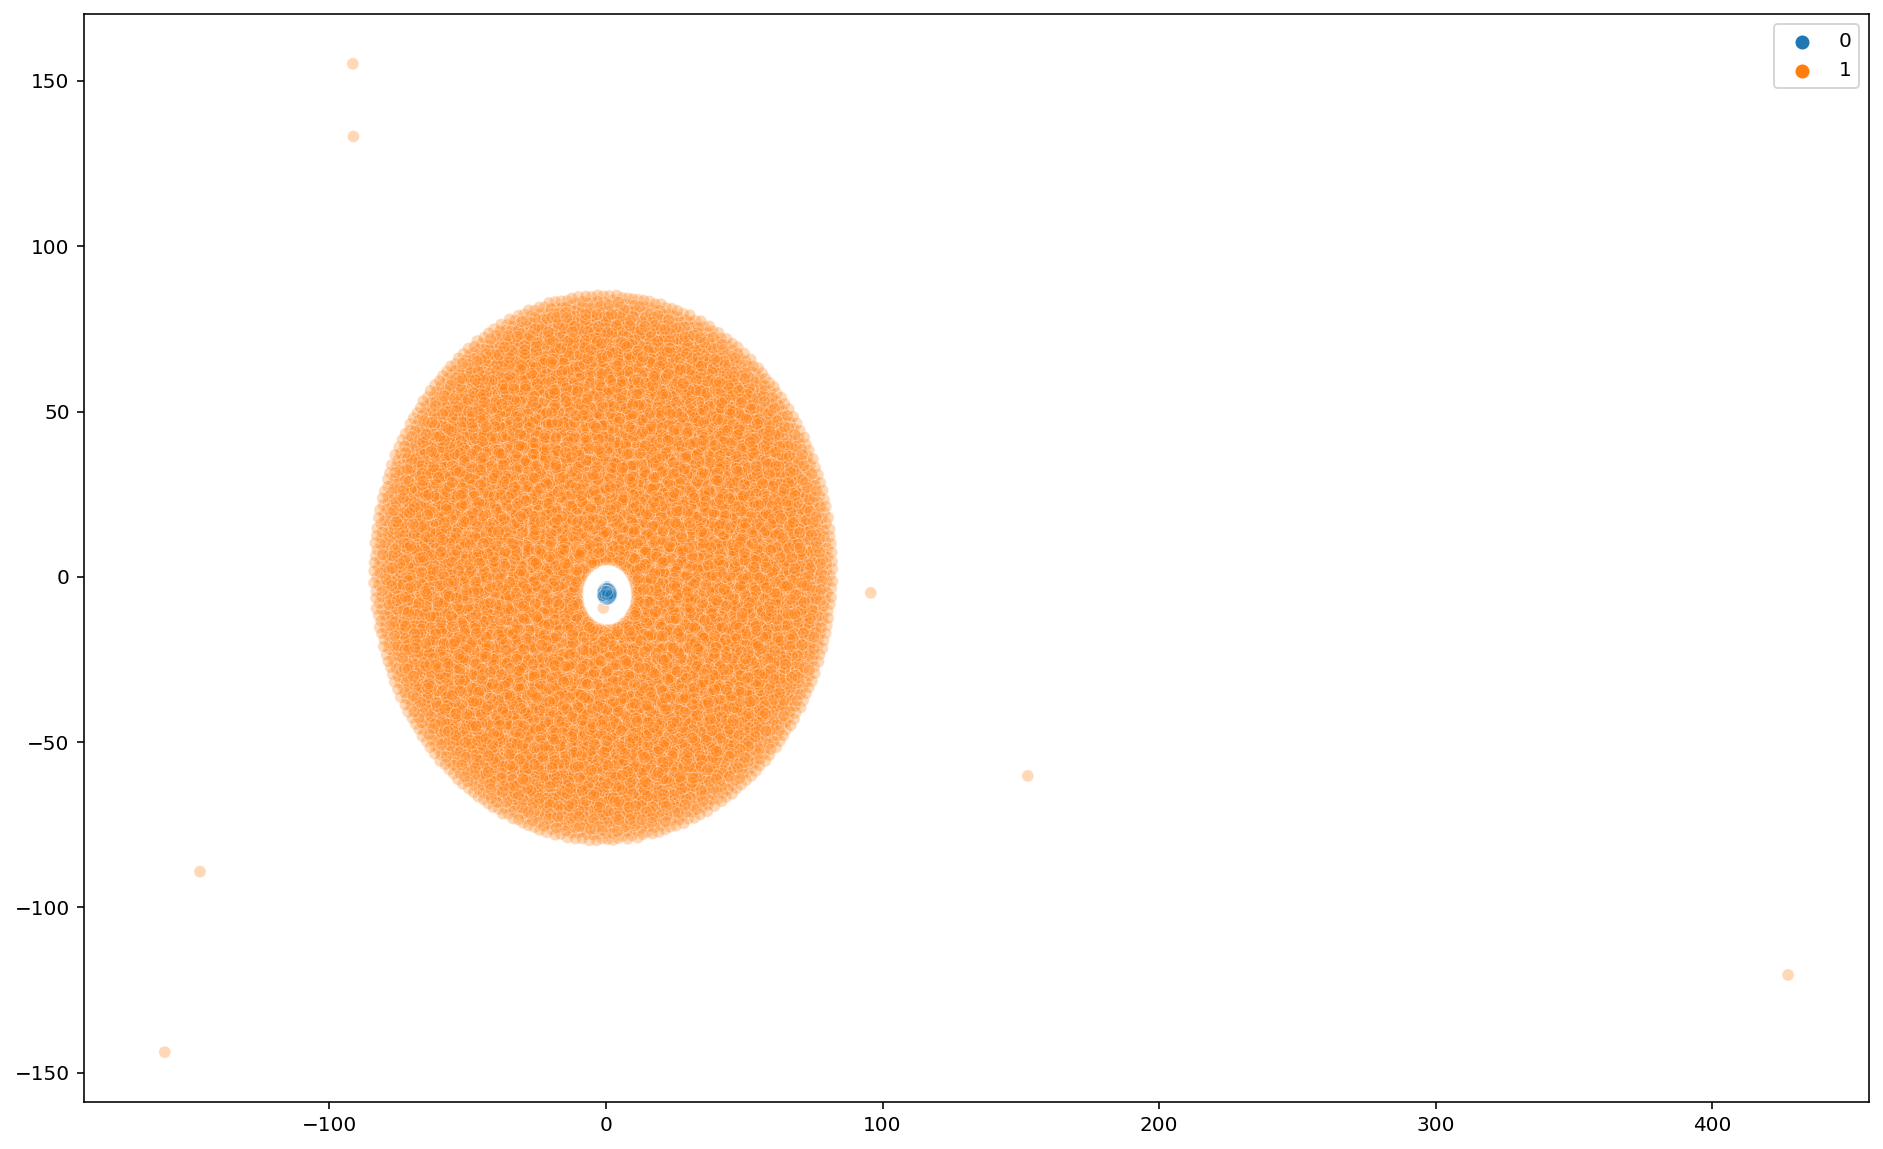

In [116]:
tfidf = TfidfVectorizer(input='content', encoding='utf-8',\
                        decode_error='strict', strip_accents='ascii',\
                        lowercase=True, preprocessor=None, tokenizer=None,\
                        analyzer='word', stop_words='english',\
                        ngram_range=(2, 2),max_df = 1, max_features=None,\
                        vocabulary=None, binary=False, norm='l2',\
                        use_idf=True, smooth_idf=True, sublinear_tf=False)
tfidf = tfidf.fit(raw_data['tweet'])
tfidf_data = tfidf.transform(raw_data['tweet'])
feature_names = tfidf.get_feature_names_out()
tsne_results_bigrams = TSNE(n_components=2, learning_rate='auto'\
                             ,init='random', perplexity=30, n_iter = 600\
                            ).fit_transform(tfidf_data)
model_data_bigram = color_graph(tsne_results_bigrams)

## TSNE Results

TSNE using both unigrams and bigrams seems to have the same results.  A ring with some spread data and a very tight core.  Just looking at some random results from each category, the groupings might be a division of hate speech vs offensive language.  I will try to match these 2 categories and check the performance.  I will only use correct answers from each category.  While categorizing the data is not my eventual goal, I want to see what happens with data this dimensionally reduced.  

### Scores
I used simple Precision, Recall, and F1 Scores.  With this data the bigrams did surprisingly well, with an 82% weighted Precision and a raw accuracy of 70%.  Note:  The weighted scores may be innacurate with no 2 values in the dataset.

### EDA Results
Even though I used an ML algorighim to perform striping, I still consider this EDA as I used basic tequniqes to find a pattern before performing more aggressvie Unstructured Learning.  I found that just paring down the data to 2 columns with bigrams I can create a model with a  70% precision.


In [118]:
def makeScores(d1, d2, text):
    print(text + ":  Raw Precision: " + str(precision_score(d1, d2, average = 'micro')) + \
          ", Weighted Precision: " + str(precision_score(d1, d2, average = 'weighted')) + \
         ", Weighted Recall: " + str(recall_score(d1, d2, average = 'weighted')) +\
         ", Weghted F1: " + str(f1_score(d1, d2, average = 'weighted')))
makeScores(model_data_unigram['predict'], raw_data['class'], "Unigram")
makeScores(model_data_bigram['predict'], raw_data['class'], "Bigram")

Unigram:  Raw Precision: 0.3471331154420369, Weighted Precision: 0.4601912622347863, Weighted Recall: 0.3471331154420369, Weghted F1: 0.28804596060676213
Bigram:  Raw Precision: 0.7008029697776702, Weighted Precision: 0.827870209493354, Weighted Recall: 0.7008029697776702, Weghted F1: 0.75900009338524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Building
I'm going to start with a DBSCAN model.  This is a popular model for text categorization and with the large doughnut hole in the middle of the data, I'm going to see if I can get the 2 blocks of data and test the results.
### DBSCAN
DBSCAN or Density-Based Spatial Clustering of Applications with Noise is a clustering algorithm that uses the density of datapoints to classify objects.